In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from DQN import qnet
from ReplayMemory import ReplayMemory

In [2]:
REPLAY_MEMORY = 10000
BATCH_SIZE = 128
LR = 1e-4
GAMMA = 0.99

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

N_ATOM = 51
V_MIN = -10.
V_MAX = 10.
V_STEP = ((V_MAX-V_MIN)/(N_ATOM-1))
V_RANGE = np.linspace(V_MIN, V_MAX, 51) # this is why C51

In [4]:
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01

In [30]:
TARGET_UPDATE_FREQ = 20
LOSS_LIST = []

In [31]:
class C51(nn.Module):
    N_ATOM = 51
    REPLAY_MEMORY = 10000
    LR = 1e-4
    VMIN = -10.
    VMAX = 10.
    TARGET_UPDATE_FREQ = 20
    BATCH_SIZE = 128
    V_STEP = ((V_MAX-V_MIN)/(N_ATOM-1))
    
    V_RANGE = np.linspace(V_MIN, V_MAX, N_ATOM)
    
    def __init__(self, inputs, outputs):
        super(C51, self).__init__()
        
        self.state_size = inputs
        self.action_size = outputs
        
        self.target_net, self.pred_net = qnet(outputs), qnet(outputs)
        self.update_target()
        
        self.pred_net.to(device) # 확률값들
        self.target_net.to(device) # 확률값들
        
        self.memory_counter = 0
        self.learn_step = 0
        
        self.replay_buffer = ReplayMemory(REPLAY_MEMORY)
        
        self.optimizer = torch.optim.Adam(self.pred_net.parameters(), lr = LR)
        
        self.value_range = torch.FloatTensor(V_RANGE).to(device)
        
    def store_transition(self, s, a, r, n_s, d):
        self.memory_counter += 1
        self.replay_buffer.push(s, a, r, n_s, d)
    
    def pick_action(self, x, ep):
        x = torch.FloatTensor(x)
        x = x.to(device)
        
        if np.random.uniform() > ep:
            action_value_dist = self.pred_net(x)
            
            # need to repair <- not good version
            action_value = torch.sum(action_value_dist * self.value_range.view(1,1,-1), dim=2)
            # action_value = torch.sum(action_value, axis=1)
            action = torch.argmax(action_value).data.cpu().numpy().item()
            action = np.array(action).reshape(1,)
#             print("EPS ", end=" ")
        else:
#             print("RANDOM", end=" ")
            action = np.random.randint(0, self.action_size, (x.size(0)))
            
        
        return action
    
    def learn(self):
        self.learn_step += 1
        if self.learn_step % TARGET_UPDATE_FREQ == 0:
            self.update_target()
            
        minibatch = self.replay_buffer.sample(BATCH_SIZE)
        
        b_s = [x[0] for x in minibatch]
        b_a = [x[1] for x in minibatch]
        b_r = [x[2] for x in minibatch]
        b_ns = [x[3] for x in minibatch]
        b_d = [x[4] for x in minibatch]
        b_d = np.array(b_d)
        
        b_w, b_idxes = np.ones_like(b_r), None
        
        b_s = torch.FloatTensor(b_s).to(device)
        b_a = torch.LongTensor(b_a).to(device)
        b_ns = torch.FloatTensor(b_ns).to(device)
        
        q_eval = self.pred_net(b_s)
        mb_size = q_eval.size(0)
        q_eval = torch.stack([q_eval[i].index_select(0, b_a[i]) for i in range(mb_size)]).squeeze(1)
        
        q_target = np.zeros((mb_size, N_ATOM))
        
        q_next = self.target_net(b_ns).detach()
        q_next_mean = torch.sum(q_next * self.value_range.view(1, 1, -1), dim=2)
        action_star = q_next_mean.argmax(dim=1)
        q_next = torch.stack([q_next[i].index_select(0, action_star[i]) for i in range(mb_size)]).squeeze(1)
        q_next = q_next.data.cpu().numpy()
        
        target_value = np.expand_dims(b_r, 1) + GAMMA * np.expand_dims((1.0 - b_d), 1) * np.expand_dims(self.value_range.data.cpu().numpy(), 0)
        target_pos = np.zeros_like(target_value)
        
        target_value = np.clip(target_value, V_MIN, V_MAX)
        target_pos = (target_value - V_MIN) / V_STEP
        
        lb = np.floor(target_pos).astype(int)
        ub = np.ceil(target_pos).astype(int)
        
        for i in range(mb_size):
            for j in range(N_ATOM):
                q_target[i, lb[i, j]] += (q_next * (ub - target_pos))[i, j]
                q_target[i, ub[i, j]] += (q_next * (target_pos - lb))[i, j]
        
        q_target = torch.FloatTensor(q_target).to(device)
        
        loss = q_target * (-torch.log(q_eval + 1e-8))
        loss = torch.mean(loss)
        
        b_w = torch.Tensor(b_w).to(device)
        loss = torch.mean(b_w * loss)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.learn_step % 10 == 0:
            print(loss.item())
        LOSS_LIST.append(loss.item())
    
    def update_target(self):
        self.target_net.load_state_dict(self.pred_net.state_dict())


In [33]:
import gym
from itertools import count
import math

EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

env = gym.make('CartPole-v1')
n_actions = env.action_space.n
n_states = env.observation_space.shape[0]

c51_net = C51(n_states, n_actions)

memory = ReplayMemory(REPLAY_MEMORY)
episodes = 200000

for i_episodes in range(episodes):
    state = np.array(env.reset()).reshape((1, -1))
    
    for t in count():
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1*t / EPS_DECAY)
        action = c51_net.pick_action(state, eps_threshold)[0]
#         print("action : ", action)
        n_s, r, d, _ = env.step(action)
        n_s = np.array(n_s).reshape((1, -1))
        c51_net.store_transition(state, action, r, n_s, d)
        
        state = n_s
        
        if d:
            break
        
        if (c51_net.memory_counter % 1000 == 0 and c51_net.memory_counter > 1):
            c51_net.learn()
            
            
            

0.0727694109082222
0.07281298190355301
0.07263410091400146
0.07275011390447617
0.07279092818498611
0.07282814383506775
0.07267224788665771
0.07261691987514496
0.07253808528184891
0.0724511370062828
0.07230577617883682
0.07208513468503952
0.0719720646739006
0.07165329158306122
0.0712994858622551
0.07090114057064056
0.0706992894411087
0.06991571187973022
0.06919369101524353
0.0683792233467102
0.06842444092035294
0.06693174690008163
0.06699128448963165
0.06554792821407318
0.06539210677146912
0.0641040951013565
0.06391314417123795
0.0623459592461586
0.06210524961352348
0.06070766597986221
0.06039448454976082
0.05748985707759857
0.057196181267499924
0.05494789779186249
0.05477690324187279
0.05639618635177612
0.056191448122262955
0.054580166935920715
0.05364828556776047
0.05280241370201111
0.05203171446919441
0.05622987076640129
0.055611275136470795
0.05483028665184975
0.054222337901592255
0.054640334099531174
0.053523626178503036
0.05466075241565704
0.054502375423908234
0.05301646888256073


KeyboardInterrupt: 

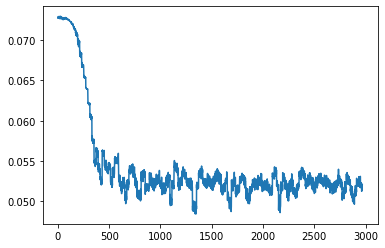

In [34]:
import matplotlib.pyplot as plt

plt.plot(LOSS_LIST)

In [35]:
plt.show()

In [40]:
def bot_play(agent):

    state = env.reset()
    state = np.array(env.reset()).reshape((1, -1))
    total_reward = 0

    while True:
#         env.render()
        action = agent.pick_action(state, -1)[0]

        state, reward, done, _ = env.step(action)
        state = np.array(state).reshape((1, -1))
        total_reward += reward

        if done:
            print("Total score: {}".format(total_reward))
            break
for _ in range(20):
    
    bot_play(c51_net)

Total score: 10.0
Total score: 10.0
Total score: 10.0
Total score: 8.0
Total score: 9.0
Total score: 10.0
Total score: 9.0
Total score: 9.0
Total score: 9.0
Total score: 9.0
Total score: 9.0
Total score: 10.0
Total score: 10.0
Total score: 9.0
Total score: 9.0
Total score: 9.0
Total score: 10.0
Total score: 9.0
Total score: 10.0
Total score: 10.0


#### OMG